In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

In [3]:
IS_FOR_KAGGLE = False

if IS_FOR_KAGGLE:
    trd = pd.read_csv('../input/train.csv')
    tsd = pd.read_csv('../input/test.csv')
else:
    trd = pd.read_csv('train.csv')
    tsd = pd.read_csv('test.csv')

td = pd.concat([trd, tsd], ignore_index=True, sort  = False)

### 1. Получение данных

In [4]:
td.shape

(1309, 12)

1309 строк и 12 столбцов

In [5]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 2. Видим, что есть пустые значения
Столбцы, в которых отсутствуют значения:

- Age
- Cabin
- Embarked
- Fare
- Survived

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

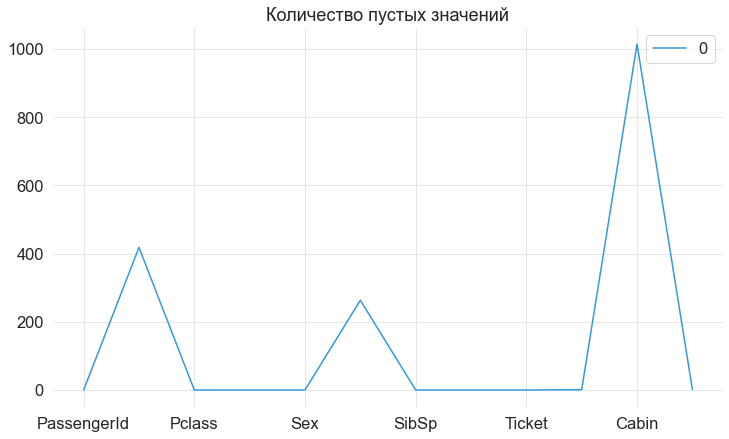

In [6]:
pd.DataFrame(td.isnull().sum()).plot.line().set_title("Количество пустых значений")
td.isnull().sum()

Text(0.5, 1.0, 'Графическое представление пустых значенийp')

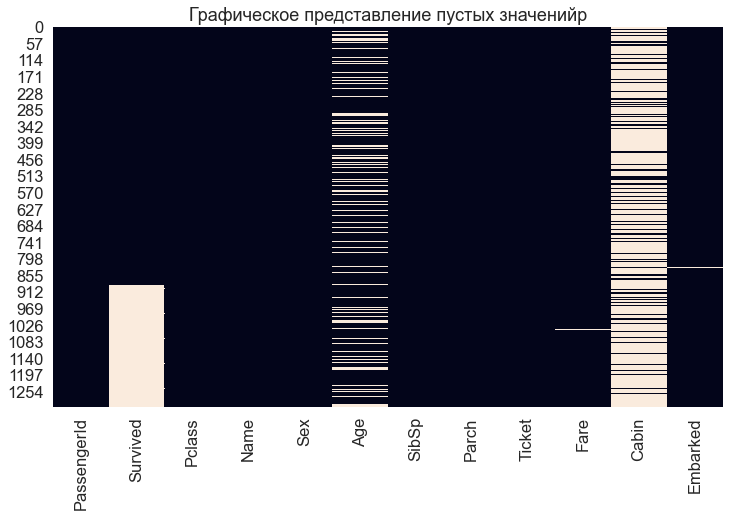

In [7]:
sns.heatmap(td.isnull(), cbar = False).set_title("Графическое представление пустых значенийp")


### 3. Количество уникальных значений

In [8]:
td.nunique()#все столбцы с количеством уникальных значений

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

### 4. Столбец "Survived" ###
Найдем соотношение между выжившими и погибшими

Text(0.5, 1.0, 'Доля выживших и погибших')

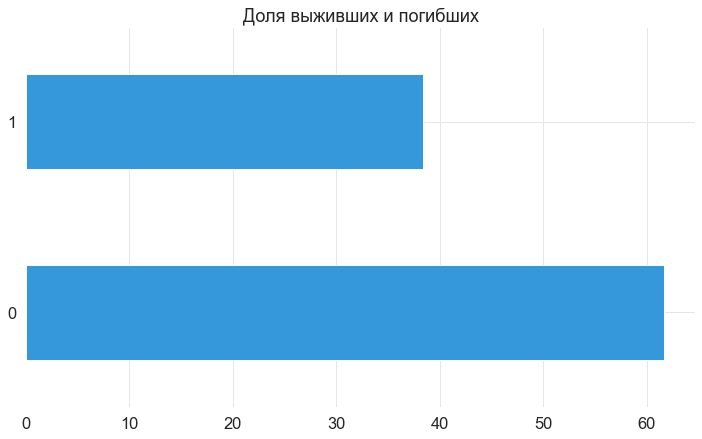

In [9]:
(trd.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("Доля выживших и погибших")


### 5. Столбец "Pclass" ###


Найдем соотношение выживших и погибших в зависимости от класса.
В результате приведенного ниже анализа, выяснили, что из пассажиров первого класса 40% было спасено.Около 70% пассажиров второго класса погибли.Более 80% пассажиров третьего класса не выжили.




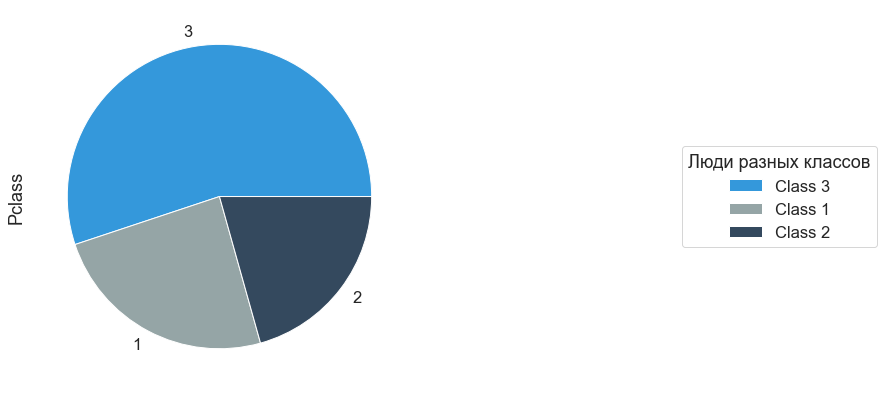

In [10]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Люди разных классов")


Text(0.5, 1.0, 'Соотношение выживших и погибших в каждом классе')

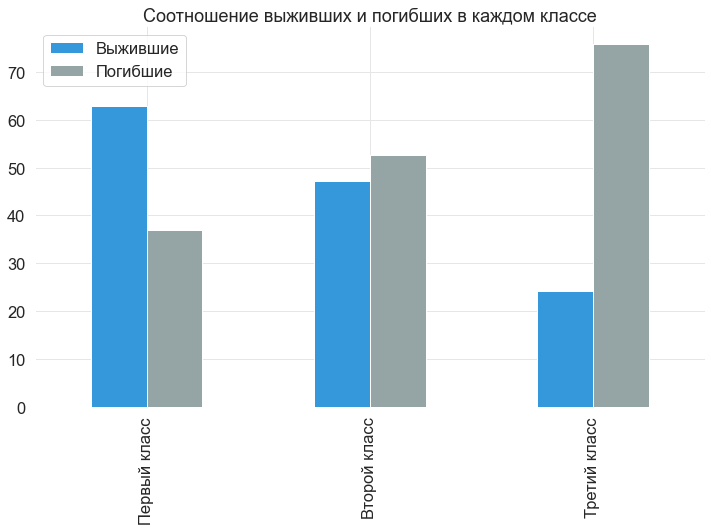

In [11]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Выжившие":{"Первый класс": pclass_1_survivor_distribution,"Второй класс": pclass_2_survivor_distribution, "Третий класс": pclass_3_survivor_distribution},  
     "Погибшие":{"Первый класс": 100-pclass_1_survivor_distribution,"Второй класс": 100-pclass_2_survivor_distribution, "Третий класс": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Соотношение выживших и погибших в каждом классе")

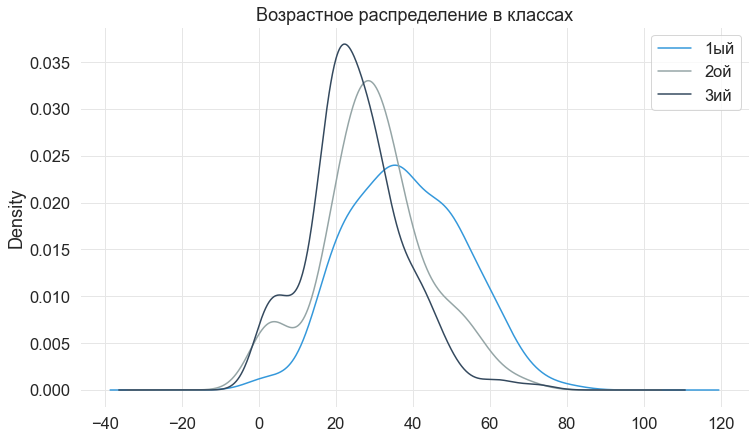

In [12]:
for x in [1,2,3]:    ## для всех классов
    trd.Age[trd.Pclass == x].plot(kind="kde")
plt.title("Возрастное распределение в классах")
plt.legend(("1ый","2ой","3ий"))

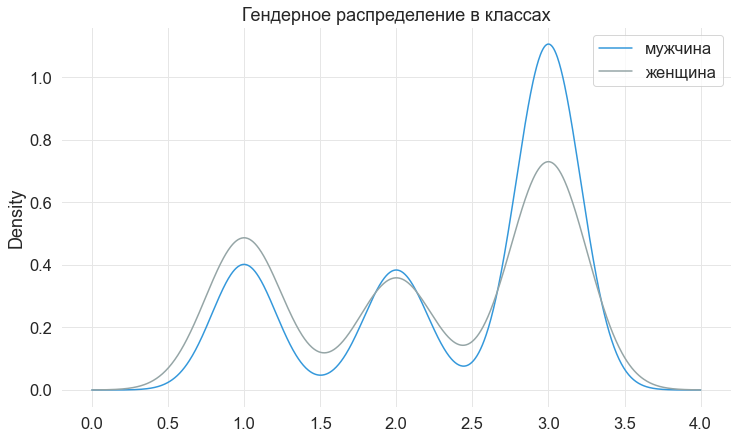

In [13]:
for x in ["male","female"]:
    td.Pclass[td.Sex == x].plot(kind="kde")
plt.title("Гендерное распределение в классах")
plt.legend(("мужчина","женщина"))

In [14]:
pclass_perc_df

,Выжившие,Погибшие
Первый класс,62.96,37.04
Второй класс,47.28,52.72
Третий класс,24.24,75.76


### 6. Столбец "Sex"

Из всех пассажиров, около 65% являлись мужчины, а остальные 35% - женщины.Процент выживших женщин оказался выше.

Более 80% пассажиров-мужчин погибли, а из женщин-70%.

<AxesSubplot:>

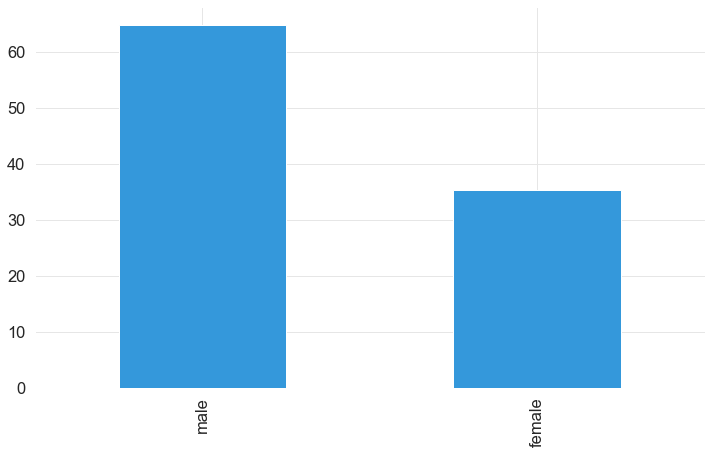

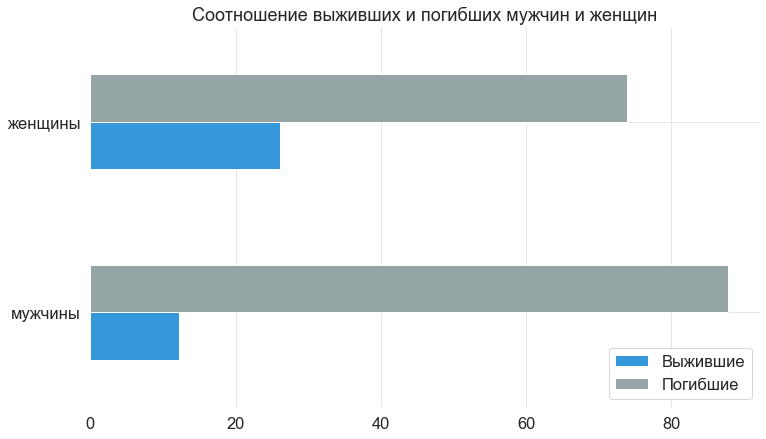

In [15]:
fig_sex = (trd.Sex.value_counts(normalize = True) * 100).plot.bar()
male_pr = round((trd[trd.Sex == 'male'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
female_pr = round((trd[trd.Sex == 'female'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
sex_perc_df = pd.DataFrame(
    { "Выжившие":{"мужчины": male_pr,"женщины": female_pr},  "Погибшие":{"мужчины": 100-male_pr,"женщины": 100-female_pr}})
sex_perc_df.plot.barh().set_title("Соотношение выживших и погибших мужчин и женщин")
fig_sex

### 7. Столбец "Age"

Возраст самомого молодого пассажира- около 2 месяцев, а самого старого- 80 лет. Средний возраст пассажиров- менее 30 лет. Самому старому пассажиру было 80 лет. Далее, будем строить график возрастного диапазона.

In [16]:
pd.DataFrame(td.Age.describe())

,Age
count,1046.000000
mean,29.881138
std,14.413493
min,0.170000
25%,21.000000
50%,28.000000
75%,39.000000
max,80.000000


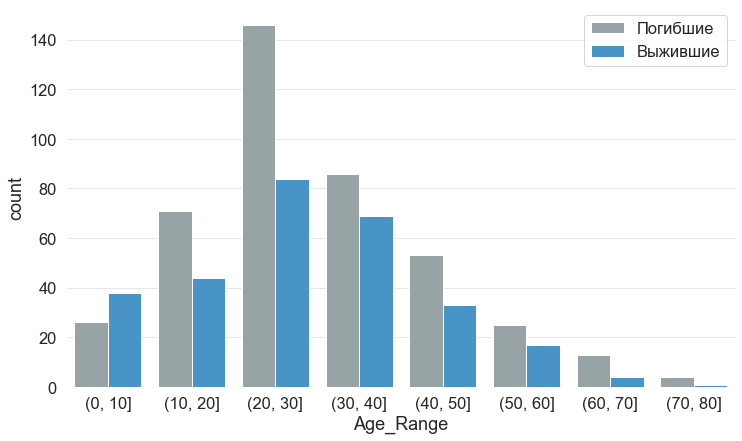

In [17]:
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.countplot(x = "Age_Range", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Погибшие", "Выжившие"])


C:\Users\danir\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

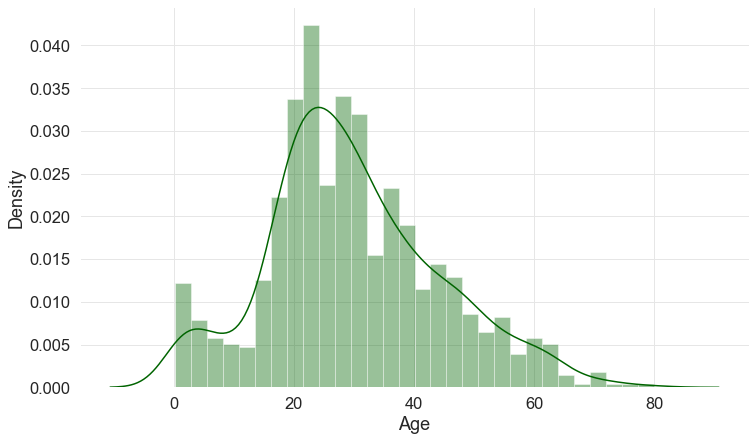

In [18]:
sns.distplot(td['Age'].dropna(),color='darkgreen',bins=30)

### 8. Столбец "SibSp"

Рассмотрим количество братьев, сестер или супругов на борту.
Более 90% людей путешествовали в одиночку или с одним из своих братьев, сестер или супругов.
Шансы на выживание падали, если пассажир путешествовал с более чем двумя братьями и сестрами.

In [19]:
td.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Text(0.5, 1.0, 'Количество родственников в сравнении с количеством выживших')

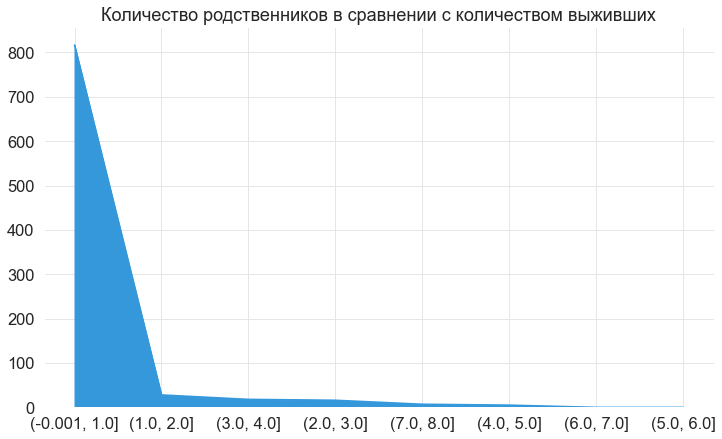

In [20]:
ss = pd.DataFrame()
ss['survived'] = trd.Survived
ss['sibling_spouse'] = pd.cut(trd.SibSp, [0, 1, 2, 3, 4, 5, 6,7,8], include_lowest = True)
(ss.sibling_spouse.value_counts()).plot.area().set_title("Количество родственников в сравнении с количеством выживших")

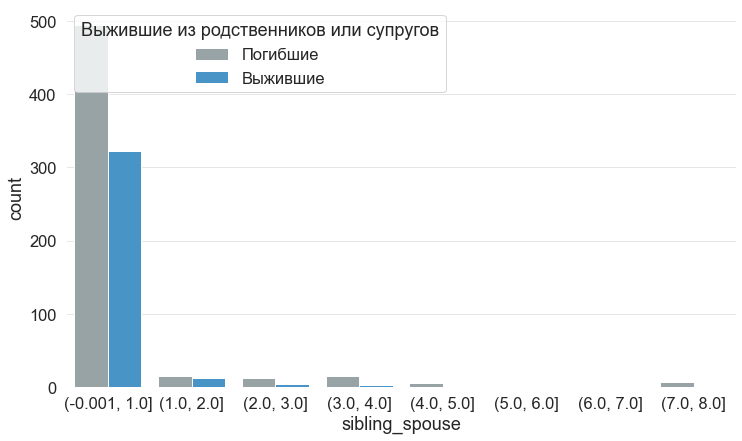

In [21]:
x = sns.countplot(x = "sibling_spouse", hue = "survived", data = ss, palette=["C1", "C0"]).legend(labels = ["Погибшие", "Выжившие"])
x.set_title("Выжившие из родственников или супругов")

### 9. Столбец"Parch"

Рассмотрим количество родителей или детей, с которыми путешествовал каждый пассажир (максимум-9 родственников путешествовало с одним из пассажиров).

Мы создадим два новых столбца, столбец с именем family будет содержать сумму количества братьев и сестер / супругов и количества родителей / детей.Также, создаем столбец Is_Alone. Можем сделать вывод, что у людей, путешествующих в одиночку, были более высокие шансы на выживание.



In [22]:
pd.DataFrame(td.Parch.describe())

,Parch
count,1309.000000
mean,0.385027
std,0.865560
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


Text(0.5, 1.0, 'Количество родителей/детей и плотность выживших')

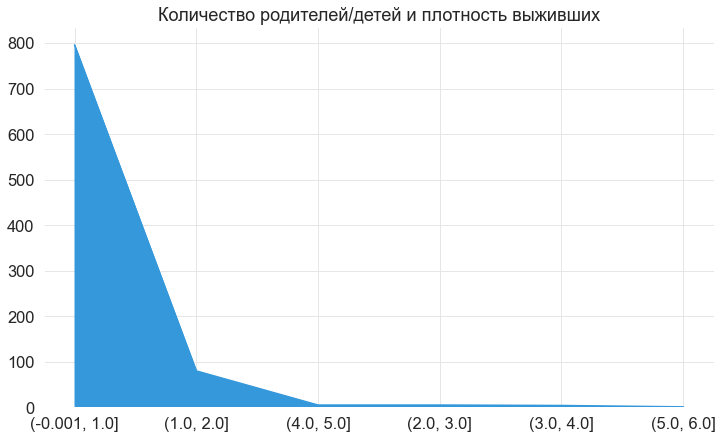

In [23]:
pc = pd.DataFrame()
pc['survived'] = trd.Survived
pc['parents_children'] = pd.cut(trd.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest = True)
(pc.parents_children.value_counts()).plot.area().set_title("Количество родителей/детей и плотность выживших")

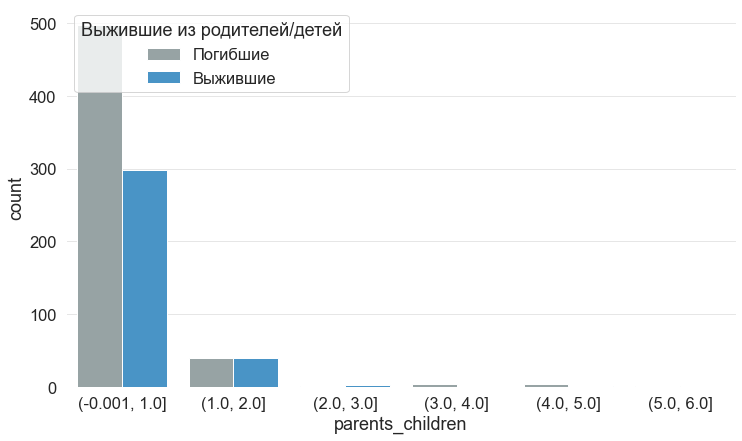

In [24]:
x = sns.countplot(x = "parents_children", hue = "survived", data = pc, palette=["C1", "C0"]).legend(labels = ["Погибшие", "Выжившие"])
x.set_title("Выжившие из родителей/детей")


In [25]:
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

### 10. Столбец"Fare"

Чем дороже билет пассажира, тем выше его шансы на выживание.

In [26]:
td.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [27]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])

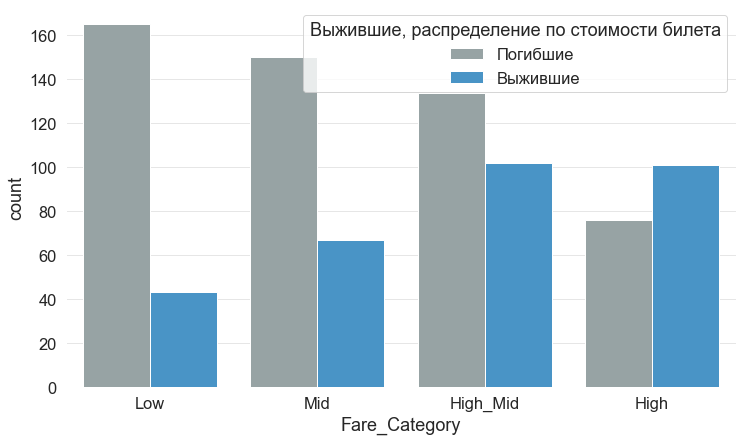

In [28]:
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Погибшие", "Выжившие"])
x.set_title("Выжившие, распределение по стоимости билета")


### 11. Столбец"Cabin"

В данном столбце много пустых значений


Embarked определяет место отправки пассажира (Саутгемптон, Шербур, Квинстаун).

По совокупным данным, более 70% людей сели из Саутгемптона. Чуть менее 20% - из Шербура, остальные - из Квинстауна.

Выжило больше людей, прибывших из Шербура.

Text(0.5, 1.0, 'Выжившие по месту отправления')

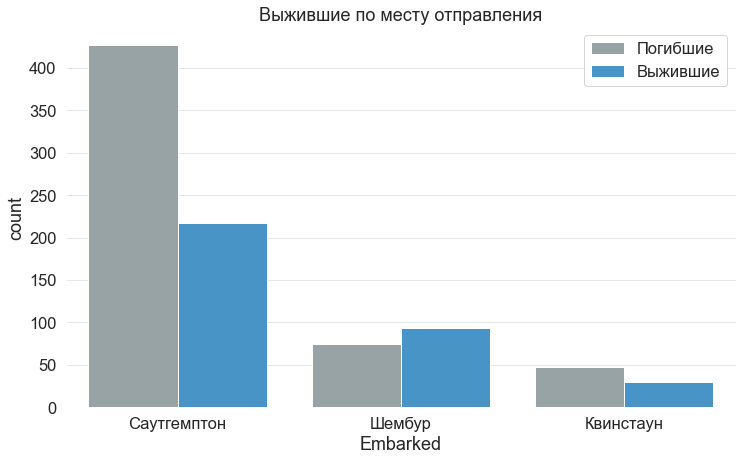

In [29]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Саутгемптон","Шембур","Квинстаун"])
p.legend(labels = ["Погибшие", "Выжившие"])
p.set_title("Выжившие по месту отправления")

# Data Imputation

### Embarked

Заменим неизвестный пункт назначения на самый вероятный( вместо того, чтобы вручную вводить Саутгемптон, мы найдем режим столбца Embarked и заменим им пропущенные значения).

In [30]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

### Age

Посчитаем средний возраст и заменим им пропущенные значения

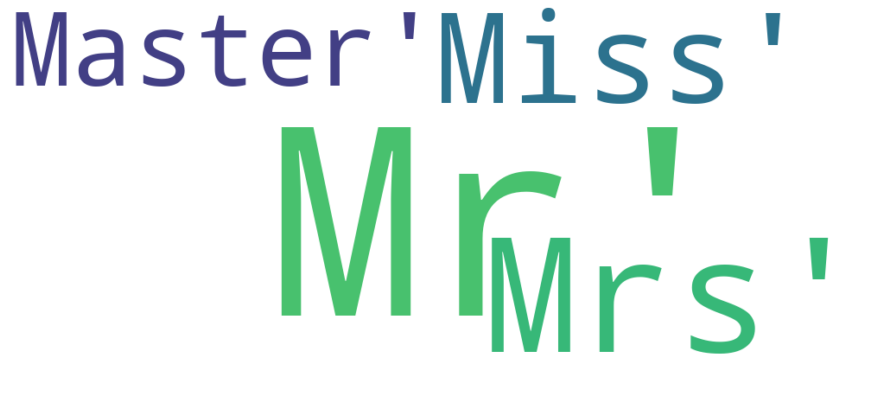

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Dona              1
Jonkheer          1
Don               1
the Countess      1
Sir               1
Capt              1
Lady              1
Mme               1
Name: Salutation, dtype: int64

In [31]:
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
td.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(td.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

td.Salutation.value_counts()

In [32]:
grp = td.groupby(['Sex', 'Pclass'])  
td.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

#на случай если еще пропущена какая-либо строка
td.Age.fillna(td.Age.median, inplace = True)

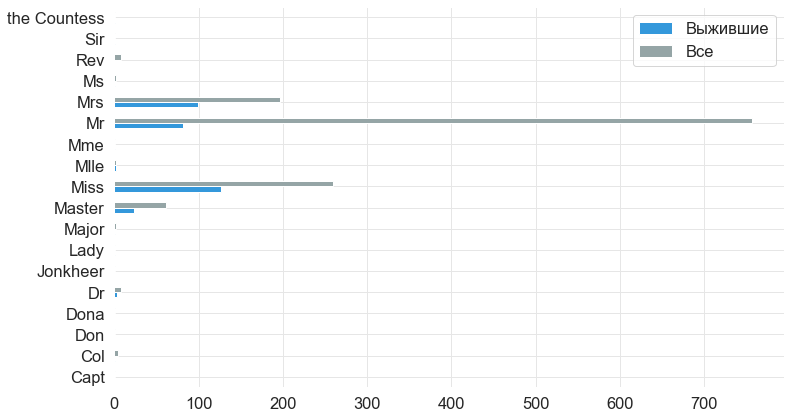

In [33]:
sal_df = pd.DataFrame({
    "Выжившие":
    td[td.Survived == 1].Salutation.value_counts(),
    "Все":
        td.Salutation.value_counts()
})
s = sal_df.plot.barh()

### Cabin

Назначение NA для пустых значений кают

In [34]:
td.Cabin = td.Cabin.fillna('NA')

# Encoding & dropping columns

Закодировали категориальные данные, далее отбрасываем все закодированные столбцы

In [35]:
td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])

In [36]:
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)


# Prediction

Используемые алгоритмы прогнозирования:

1. Gaussian Naive Bayes
2. Random Forest

NB Accuracy: 60.34%
The cross validated score for GNB is: 66.29


Text(0.5, 1.05, 'Confusion_matrix for NB')

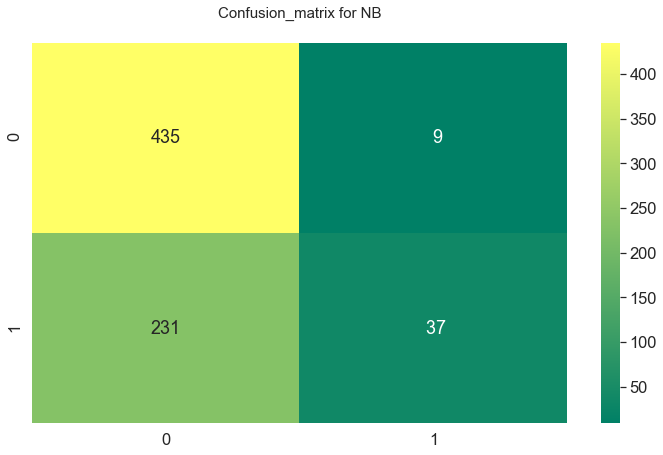

In [37]:
#прогнозируемые данные
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

#обучаемые данные
train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

##Gaussian
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("NB Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for GNB is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for NB', y=1.05, size=15)

In [ ]:
##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

RF Accuracy: 84.92%


In [ ]:
result = clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)